In [1]:
# We could probably do fewer imports but would there be a benefit. 
import numpy as np
from numpy import loadtxt
import glob
import os
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.color import label2rgb
from scipy import ndimage as ndi
from skimage.measure import label, regionprops  
from skimage.color import label2rgb              
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import filtfilt
from scipy.interpolate import BSpline
import csv
from skimage.draw import circle
import pandas as pd

In [2]:
# Takes the results of the histogram segmentation and removes regions which are not between 
# 900-1400 pixels in size and who have major and minor axes which have greater than a 10 pixel 
# difference. 
# This is a relatively crude metric - required me to tune pixel sizes but shouldn't vary much
# going forward.  Can use Hough circles in next version...

# Inputs: Histogram segmented image to be masked, regionproperties.
# Outputs: masked image
def Clean_Sample(major_axis,minor_axis, size,coordinates,image):
    if 900 < size < 1400 and abs(major_axis - minor_axis) <= 10:
        pass
    else: 
        for pixel in coordinates:
            image[pixel[0]][pixel[1]] = 0
    

In [3]:
# Takes a segmented image and creates a new image with a small region of plate pixels below each 
# segmented sample region. 
# Inputs: starting image - cleaned image, with cleaned centroids and coordinates. 
# Output plate regions
def Plate_Plotter(starting_image, centroids, number_cleaned_regions, old_cords):
    plateregions_cleaned = starting_image.copy()
    plate_reg_colour = number_cleaned_regions + 1
    for region in centroids:
        row = (region[0] + 68).astype(int) # 68 pixels below centroid of sample - completely arb. 
        col = (region[1]).astype(int)
        patch = circle(row,col, 10) # 10 pixel sample region also - arb. 
        plateregions_cleaned[patch[0],patch[1]] = plate_reg_colour
        plate_reg_colour +=1 
    for region in old_cords:
        for pixel in region:
            plateregions_cleaned[pixel[0]][pixel[1]] = 0
        
    return plateregions_cleaned # plate regions segmented image

In [4]:
# Finds the peak in the first-derivative of a plot of sample signal (measured as temperature)
# against plate temperature. I found that filtfilt had an alarming tendency to get rid of the
# signal - so I got rid of it. 


def melt_temp_simple(plate_temp, sample_temp,name):
    
    f = interp1d(plate_temp, sample_temp, bounds_error=False)
    x = np.linspace(min(plate_temp), max(plate_temp), len(plate_temp))
    interp_sample_temp = f(x)
    
    # Combines x and y
    gradient_array = np.column_stack((x,interp_sample_temp))

    
    # Calculating first gradient
    first_gradient = np.gradient(gradient_array,axis=0)
    
    #Why do we do this?
    first_derivative = first_gradient[:][:,1]/first_gradient[:][:,0]
   

  
    # Finding peaks in the derivative plot, prominence filter to remove small peaks
    peaks, properties = find_peaks(first_derivative, prominence = 0.4, height=0, width = 0)
    
    if len(peaks) == 0:
        print("no peaks")
    else:
        peaks = list(peaks) 
        peak_heights = list(properties['peak_heights'])
        peak_width = list(properties['widths'])
        for width in peak_width:
            if width > 800:
                peak_heights.pop(peak_width.index(width))
        
        max_height = max(peak_heights)
        peaks_index = peak_heights.index(max_height) # index in peaks of max height
        melt_index = peaks[peaks_index] # peaks itself is a list of indices - so this is the index
                                        # in the data itself. 
    
    #save figure for logging 
        plt.plot(plate_temp, interp_sample_temp)
        plt.axvline(plate_temp[melt_index], color = 'g')
        plt.xlabel("Plate temperature / C")
        plt.ylabel("Sample Signal")
        plt.title(name)
        plt.savefig(name, facecolor = 'w', dpi = 1200)
        plt.close()
        
    return(plate_temp[melt_index]) # temperature in plate when signal change occurs

In [5]:
#makes sample and plate segmentation ('masks that go over the image')
#Inputs: path to data, shortner defines the subset of the data that is used for the segmentation.
# From experience need about 20 samples for the segmentation to properly work. 
#Outputs: segmentaion 

def Make_Masks(path, shortner, mask_name):
    
    full_list = glob.glob(path)
    full_list.sort(key=os.path.getmtime)
    
    
    files_list = full_list[::shortner] # skip every shortner file
    print(len(files_list))
        
    average_file = np.zeros((480,521)) # should use shape rather than hardcode size - will fix.
    
    for file in files_list:
        lines = loadtxt(file, comments="#", delimiter=",", unpack=False)
        average_file += lines
    
    average_file = average_file/len(files_list)
    
    #creates binary image by histogram filter
    average_histo_filter = average_file > 250 # arbitraty limit - could set automatically in future
    average_cleaned = morphology.remove_small_objects(average_histo_filter, 800) 
    
    #label average filter and get properties
    average_labeled, number_regions_raw = ndi.label(average_cleaned)
    average_properties_raw = regionprops(average_labeled, intensity_image = average_file)
    major_diameters = [i.minor_axis_length for i in average_properties_raw]
    minor_diameters = [i.major_axis_length for i in average_properties_raw]
    area = [i.area for i in average_properties_raw]
    coords = [i.coords for i in average_properties_raw]
    
    # copy origanl filtered image to clean up. 
    filter_labeled = average_labeled.copy()
    
    # cleans up averaged segmentaion - filter_labeled = output
    for num in major_diameters:
        index = major_diameters.index(num)
        Clean_Sample(major_diameters[index], minor_diameters[index], area[index], coords[index], filter_labeled)

    _, number_filt_reg = ndi.label(filter_labeled)
    
    #properties of the cleaned image  - needed to make sure plate regions made correctly
    average_properties_cleaned = regionprops(filter_labeled, intensity_image = average_file)
    cleaned_centroids = [i.centroid for i in average_properties_cleaned]
    cleaned_coords = [i.coords for i in average_properties_cleaned]

    plate_labeled = Plate_Plotter(filter_labeled, cleaned_centroids,\
                                  number_filt_reg, cleaned_coords)
    
    
    #saves final segmentation as contours over the average image - used as a check. 
    plt.imshow(average_file)
    plt.colorbar()
    plt.contour(filter_labeled, [0.5], linewidths=2, colors='r')
    plt.contour(plate_labeled, [0.5], linewidths = 2, colors = 'b')
    plt.savefig(mask_name, facecolor = 'w', dpi = 1200)
    plt.close()
    
    return filter_labeled, plate_labeled, number_filt_reg
   

In [6]:
# Uses segmentation/masks to read the temperatures of the samples and the plate and write them 
# to a csv file. 
# Inputs - sample segmentation/mask, plate segmentation/mask, number of segmented sample regions
# name of results file (out_file), path to data
# Outputs - csv out_file of segmented data. 

def Data_grabber(sample_mask, plate_mask, number_samples, out_file, path):
    
    file_list = glob.glob(path)
    file_list.sort(key=os.path.getmtime)
    
    frame_data = {}
    
    #creates a 'dictionary of dictionaries' with a variable number of entries depending on the 
    # number of samples it found during segmentation. 
    
    sample_index = list(range(0,number_samples,1))
    
    for sample in sample_index:
        name = f"Sample_{sample}"
        frame_data[name] = {"Centroid Temperature" : [], "Mean Temperature" : [],\
                            "Plate Mean Temperature": []}
 
    
    # reads the data from each frame this part takes the longest.     
    for file in file_list:
       
        frame =  loadtxt(file, comments="#", delimiter=",", unpack=False)
        frame_regions = regionprops(sample_mask, intensity_image = frame)
        plate_regions = regionprops(plate_mask, intensity_image = frame)
   
        average_intensity = [i.mean_intensity for i in frame_regions]
        rounded_average_intensity =  [round(i, 2) for i in average_intensity]
        centroids = [i.centroid for i in frame_regions]
        rounded_centroids = np.round(centroids).astype(int)
        centroid_temperatures = []
        for centre in rounded_centroids:
            row = centre[0]
            col = centre[1]
            centroid_temperatures.append(frame[row][col])
        average_plate_temperature = [i.mean_intensity for i in plate_regions]
        rounded_average_plate_temperature = [round(i, 2) for i in average_plate_temperature]
    
    # writes frame information to the dictionary
        for sample in sample_index:
            frame_data[f"Sample_{sample}"]\
            ["Mean Temperature"].append(rounded_average_intensity[sample])
            frame_data[f"Sample_{sample}"]\
            ["Centroid Temperature" ].append(centroid_temperatures[sample])
            frame_data[f"Sample_{sample}"]\
            ["Plate Mean Temperature"].append(rounded_average_plate_temperature[sample])
    
    # writes completed dictionary to an excel file - each sample gets its own sheet. 
    with pd.ExcelWriter(out_file) as writer:  # doctest: +SKIP
        for sample in sample_index:
            name = f"Sample_{sample}"
            dataframe_toexcel = pd.DataFrame(frame_data[name])
            dataframe_toexcel.to_excel(writer,sheet_name = name, index = False)
    writer.close()
    
    return frame_data # return dictionary of samples 

In [7]:
# Uses melt_temp_simple to get plate temperature at sample signal change and write it to a dictionary.
# Inputs - sample and plate tempereature results, number of samples
# Outputs - melting temperatures for each sample 

def Get_Melt_Temp(results_array,number_samples):
    
    temperature_results = {}
    sample_index = list(range(0,number_samples,1))
    
    for sample in sample_index:
        name = f"Sample_{sample}"
        temperature_results[name] = []
        
    for sample in sample_index:
        name = f"Sample_{sample}"
        
        #need to do a fairly arbitrary cut off of the sample temperature/plate temperature so that we 
        
        plate_temperatures = results_array[f"Sample_{sample}"]["Plate Mean Temperature"][:510] 
        sample_temperatures = results_array[f"Sample_{sample}"]["Centroid Temperature"][:510]
        sample_melt = melt_temp_simple(plate_temperatures, sample_temperatures, name)
        temperature_results[f"Sample_{sample}"].append(sample_melt)
    
        
       
    return temperature_results

In [26]:
segmentation_masks = Make_Masks('post-main board heat test 100mK correct res/*.txt', 100, 'post-main board')

13


In [27]:
results = Data_grabber(segmentation_masks[0], segmentation_masks[1], segmentation_masks[2]\
             , 'post-main board.xlsx', 'post-main board heat test 100mK correct res/*.txt')

In [28]:
temps = Get_Melt_Temp(results,14)

In [29]:
results_image = \
loadtxt('post-main board heat test 100mK correct res frame 12.txt', comments="#", delimiter=",", unpack=False)
regions_segmentation = segmentation_masks[1]
props = regionprops(regions_segmentation, intensity_image = results_image)
centroids = [(i.centroid) for i in props]

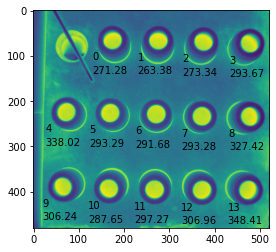

In [30]:
plt.imshow(results_image)

for i in range(14):
    #print(temps[f"Sample_{i}"])
    plt.annotate(i, (centroids[i][1] - 45, centroids[i][0] - 25))
    plt.annotate(str(temps[f"Sample_{i}"][0]), (centroids[i][1] -45, centroids[i][0]+5))

plt.savefig('post-main board heat test 100mK correct res frame 12', facecolor = 'w', dpi = 1200)


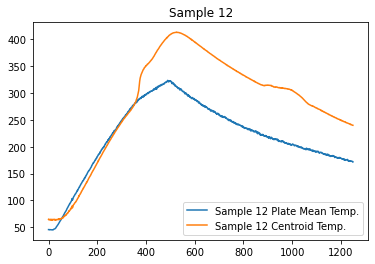

In [31]:
plt.plot(results[f"Sample_{12}"]["Plate Mean Temperature"], label = "Sample 12 Plate Mean Temp.")
plt.plot(results[f"Sample_{12}"]["Centroid Temperature"], label = "Sample 12 Centroid Temp.")
plt.legend()
plt.title("Sample 12")
plt.savefig('Sample 3', facecolor = 'w', dpi = 1200)

#plt.plot(results[f"Sample_{12}"]["Centroid Temperature"])

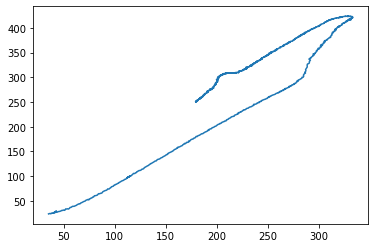

In [15]:
plt.plot(results[f"Sample_{12}"]["Plate Mean Temperature"],results[f"Sample_{13}"]["Centroid Temperature"])
